# Capstone project report - Week 6
## Analysis of tennis tournament data of ATP World Tour
<center><img src="images/ATP_World_Tour.png" alt="ATP World Tour" style="width: 200px;" align="center"/></center>

## *Robert Seidl*
Data from https://github.com/JeffSackmann

# This week
## Supervised learning
- Age - Performance curve for ATP Tour players
- Inspect variation of player statistics for player (e.g. Stan Wawrinka)

## Unsupervised learning
- Group players by their average statistics (k-means)
- Visualize clusters using PCA



In [2]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import os
import glob
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
import warnings
warnings.filterwarnings('ignore')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
players = pd.read_csv('atp-data/atp_players.csv', header=None,names = ["playerId", "first_name", "last_name", "hand",'birthdate','nationality'])
players.head()

,playerId,first_name,last_name,hand,birthdate,nationality
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA


In [4]:
columns = ['tourney_id','tourney_name','surface','draw_size',
            'tourney_level','tourney_date','match_num',
            'winner_name','loser_name','score','best_of','round','minutes',
           'winner_hand','winner_ht','winner_age','w_ace','w_df','w_svpt','w_1stIn',
           'w_1stWon','w_2ndWon','w_SvGms','w_bpSaved','w_bpFaced',
           'loser_hand','loser_ht','loser_age','l_ace','l_df','l_svpt','l_1stIn',
           'l_1stWon','l_2ndWon','l_SvGms','l_bpSaved','l_bpFaced']
atp_matches2015 = pd.read_csv('atp-data/atp_matches_2015.csv',dtype={'playerId': np.int32},parse_dates=True, names = columns)


In [5]:
def get_merged_csv(flist, **kwargs):
    return pd.concat([pd.read_csv(f, **kwargs) for f in flist], ignore_index=True)



files = ['atp-data/atp_matches_201{}.csv'.format(i) for i in range(0,7)]

df = get_merged_csv(files)
df.head()

df.drop(axis=1,labels=['match_num','winner_seed','winner_entry','winner_ioc','winner_rank_points','loser_seed','loser_entry','loser_ioc','loser_rank_points'], inplace=True)
print(df.shape)
df.head()

(20872, 40)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_name,winner_hand,winner_ht,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2010-301,Auckland,Hard,28,A,20100111,103752,Simon Greul,R,185.0,...,9.0,0.0,6.0,64.0,42.0,22.0,11.0,9.0,8.0,12.0
1,2010-301,Auckland,Hard,28,A,20100111,104545,John Isner,R,206.0,...,5.0,5.0,5.0,89.0,56.0,37.0,22.0,15.0,4.0,7.0
2,2010-301,Auckland,Hard,28,A,20100111,104338,Juan Monaco,R,185.0,...,2.0,4.0,2.0,53.0,29.0,18.0,8.0,7.0,5.0,9.0
3,2010-301,Auckland,Hard,28,A,20100111,103967,Michael Lammer,R,185.0,...,11.0,5.0,3.0,67.0,35.0,21.0,18.0,12.0,1.0,5.0
4,2010-301,Auckland,Hard,28,A,20100111,104907,Jose Rubin Statham,R,183.0,...,9.0,10.0,3.0,75.0,47.0,29.0,10.0,10.0,12.0,17.0


In [6]:
player_group = df.groupby('winner_name')['surface','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']


Clay          Axes(0.1,0.559091;0.363636x0.340909)
Grass    Axes(0.536364,0.559091;0.363636x0.340909)
Hard              Axes(0.1,0.15;0.363636x0.340909)
dtype: object

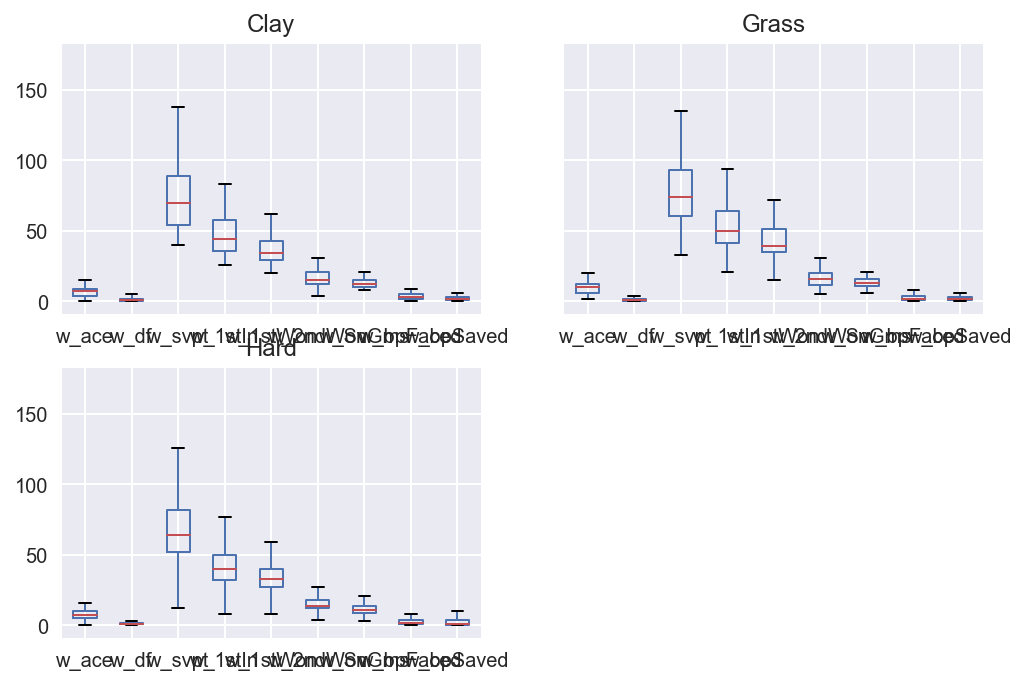

In [7]:
player_group.get_group('Roger Federer').groupby('surface').boxplot()

In [9]:
player_stats = df[['winner_name','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']].groupby(['winner_name']).filter(lambda x: len(x) > 100).groupby(['winner_name']).agg(['mean', 'count'])

player_stats.loc['Andy Murray']['w_ace']

mean       7.25
count    392.00
Name: Andy Murray, dtype: float64

# Clustering of players by stats

In [10]:
stats_columns = ['winner_name','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']
df['count'] = df.groupby('winner_name')['winner_name'].transform('count')
player_statistics = df.loc[df['count'].sort_values(ascending=False).index][stats_columns].groupby(['winner_name'], sort=False).agg(['mean'])
player_statistics.iloc[:10]

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Novak Djokovic,5.300211,1.951374,73.911205,48.346723,36.391121,14.822410,12.289641,4.253700,2.904863
Andy Murray,7.250000,2.308673,77.206633,46.418367,35.742347,16.875000,12.688776,4.966837,3.339286
Rafael Nadal,3.095718,1.513854,70.299748,48.251889,35.821159,12.833753,11.642317,4.312343,3.040302
Roger Federer,7.760925,1.419023,71.123393,45.023136,36.164524,15.632391,12.262211,3.056555,2.215938
David Ferrer,3.103627,2.225389,73.246114,46.406736,34.119171,15.344560,11.888601,4.841969,3.290155
Tomas Berdych,8.446991,2.134670,73.664756,42.636103,34.378223,17.538682,12.177650,3.971347,2.896848
Stanislas Wawrinka,7.968531,2.500000,82.639860,47.867133,37.034965,20.094406,13.279720,4.744755,3.423077
Jo Wilfried Tsonga,10.773723,2.383212,81.226277,50.478102,40.467153,17.310219,13.401460,4.051095,2.996350


In [11]:
# over all courts
stats_columns = ['winner_name','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']
df['count'] = df.groupby('winner_name')['winner_name'].transform('count')
player_statistics = df.loc[df['count'].sort_values(ascending=False).index][stats_columns].groupby(['winner_name'], sort=False).agg(['mean'])
player_statistics.iloc[:10]

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Novak Djokovic,5.300211,1.951374,73.911205,48.346723,36.391121,14.822410,12.289641,4.253700,2.904863
Andy Murray,7.250000,2.308673,77.206633,46.418367,35.742347,16.875000,12.688776,4.966837,3.339286
Rafael Nadal,3.095718,1.513854,70.299748,48.251889,35.821159,12.833753,11.642317,4.312343,3.040302
Roger Federer,7.760925,1.419023,71.123393,45.023136,36.164524,15.632391,12.262211,3.056555,2.215938
David Ferrer,3.103627,2.225389,73.246114,46.406736,34.119171,15.344560,11.888601,4.841969,3.290155
Tomas Berdych,8.446991,2.134670,73.664756,42.636103,34.378223,17.538682,12.177650,3.971347,2.896848
Stanislas Wawrinka,7.968531,2.500000,82.639860,47.867133,37.034965,20.094406,13.279720,4.744755,3.423077
Jo Wilfried Tsonga,10.773723,2.383212,81.226277,50.478102,40.467153,17.310219,13.401460,4.051095,2.996350


In [12]:
top30 = player_statistics.iloc[:20]
# add Karlovic such that Isner is not alone in cluster !
top30_list = [top30, player_statistics[player_statistics.index.str.contains('Karlovic')]]
top30p = pd.concat(top30_list)
    
labels = top30p.index.tolist()
features = top30p.as_matrix()



In [13]:
player_statistics[player_statistics.index.str.contains('Karlovic')]

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Ivo Karlovic,20.524096,3.072289,79.825301,52.722892,45.054217,15.584337,13.409639,2.644578,2.114458


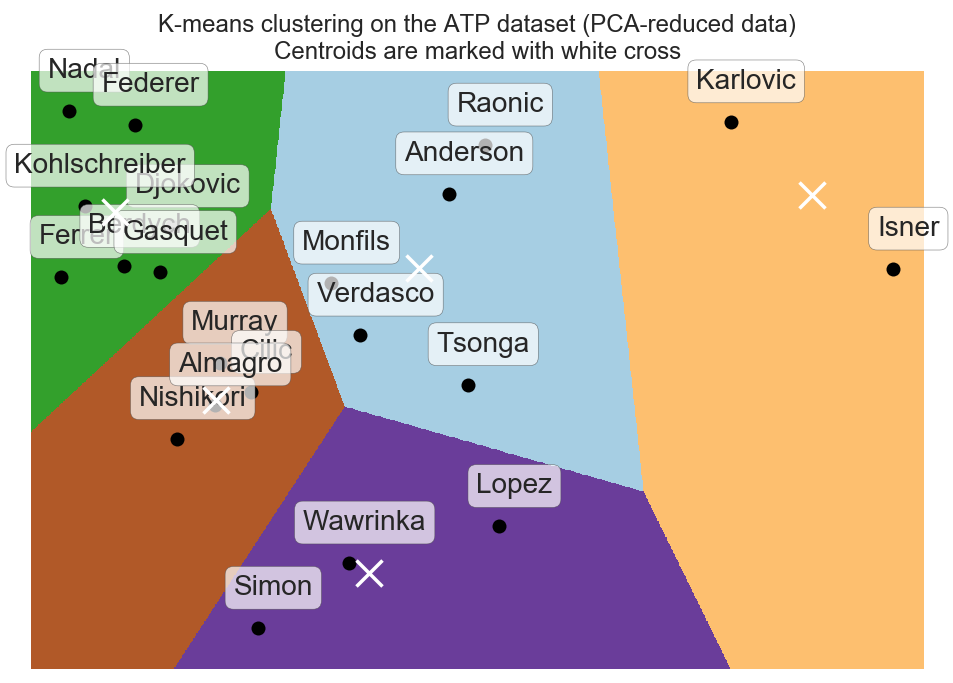

[1 4 1 1 1 1 3 0 4 4 2 1 0 0 3 4 1 0 3 0 2]
['Novak Djokovic', 'Andy Murray', 'Rafael Nadal', 'Roger Federer', 'David Ferrer', 'Tomas Berdych', 'Stanislas Wawrinka', 'Jo Wilfried Tsonga', 'Marin Cilic', 'Kei Nishikori', 'John Isner', 'Richard Gasquet', 'Milos Raonic', 'Gael Monfils', 'Gilles Simon', 'Nicolas Almagro', 'Philipp Kohlschreiber', 'Kevin Anderson', 'Feliciano Lopez', 'Fernando Verdasco', 'Ivo Karlovic']
[ 16.40603531   2.86517125]
[ 19.05185594   1.04233818]


In [15]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

def plot_clustering(data, labels, n_clusters=5, image_name = 'clustering'):
    #n_clusters = 5
    #data = X

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=14)
    
    for i,label in enumerate(labels):
        #ax.annotate(label.split()[-1], xy=(reduced_data[i,0], reduced_data[i,1]), xytext=(reduced_data[i,0]+.25, reduced_data[i,1]+.25))
        bbox_props = dict(boxstyle="round", fc="w", ec="0.3", alpha=0.7)
        ax.text(reduced_data[i,0]+.5, reduced_data[i,1]+1, label.split()[-1], ha="center", va="center", size=14, bbox=bbox_props)

    
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the ATP dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    fig.savefig('images/week6/{}.png'.format(image_name), bbox_inches="tight")

    print(kmeans.labels_)
    print(labels)
    print(centroids[2])
    print(reduced_data[10,:])
    
plot_clustering(features,labels,image_name ='general_clustering')

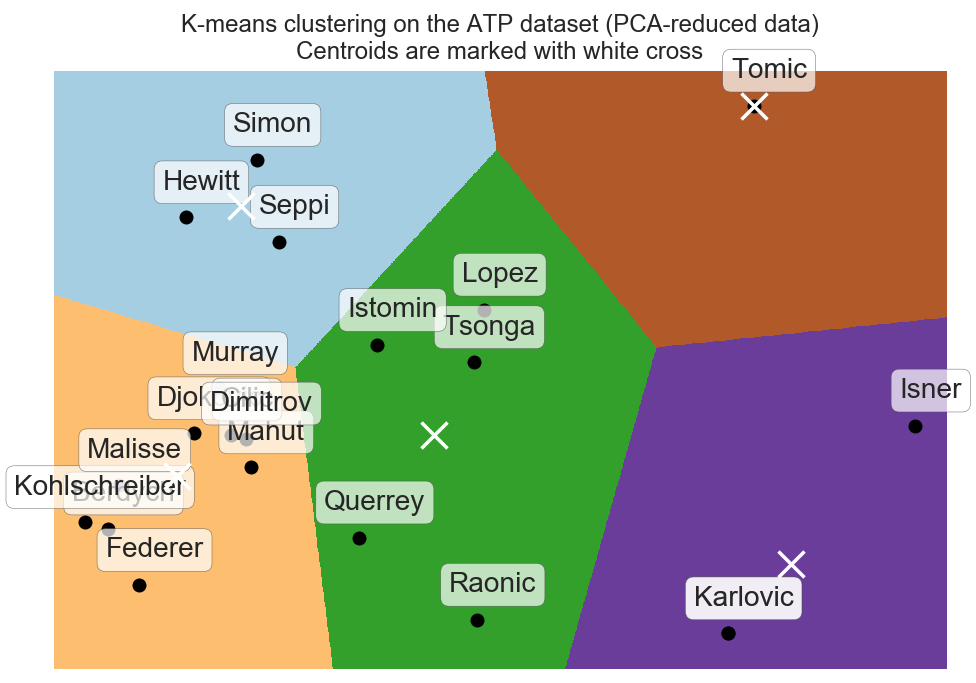

[2 2 2 2 1 1 1 0 2 2 3 2 0 1 3 2 4 1 2 0 3]
['Andy Murray', 'Roger Federer', 'Novak Djokovic', 'Nicolas Mahut', 'Feliciano Lopez', 'Sam Querrey', 'Jo Wilfried Tsonga', 'Lleyton Hewitt', 'Marin Cilic', 'Tomas Berdych', 'John Isner', 'Philipp Kohlschreiber', 'Andreas Seppi', 'Denis Istomin', 'Ivo Karlovic', 'Xavier Malisse', 'Bernard Tomic', 'Milos Raonic', 'Grigor Dimitrov', 'Gilles Simon', 'Ivo Karlovic']
[-5.97016236 -1.51730149]
[ 17.79143269  -0.08498537]


,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Andy Murray,7.250000,2.308673,77.206633,46.418367,35.742347,16.875000,12.688776,4.966837,3.339286
Roger Federer,7.760925,1.419023,71.123393,45.023136,36.164524,15.632391,12.262211,3.056555,2.215938
Novak Djokovic,5.300211,1.951374,73.911205,48.346723,36.391121,14.822410,12.289641,4.253700,2.904863
Nicolas Mahut,8.800000,2.736842,75.936842,46.715789,36.684211,15.873684,12.305263,4.263158,3.094737
Feliciano Lopez,12.417431,3.353211,84.146789,48.922018,39.165138,19.692661,13.463303,4.903670,3.706422


In [16]:
# grass
stats_columns = ['winner_name','surface','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']
df['count'] = df[df['surface']=='Grass'].groupby('winner_name')['winner_name'].transform('count')
player_statistics = df.loc[df['count'].sort_values(ascending=False).index][stats_columns].groupby(['winner_name'], sort=False).agg(['mean'])

top30 = player_statistics.iloc[:20]
top30_list = [top30, player_statistics[player_statistics.index.str.contains('Karlovic')]]
top30p = pd.concat(top30_list)
    
labels = top30p.index.tolist()
features = top30p.as_matrix()

plot_clustering(features,labels,image_name = 'clustering_grass')

top30p.head()

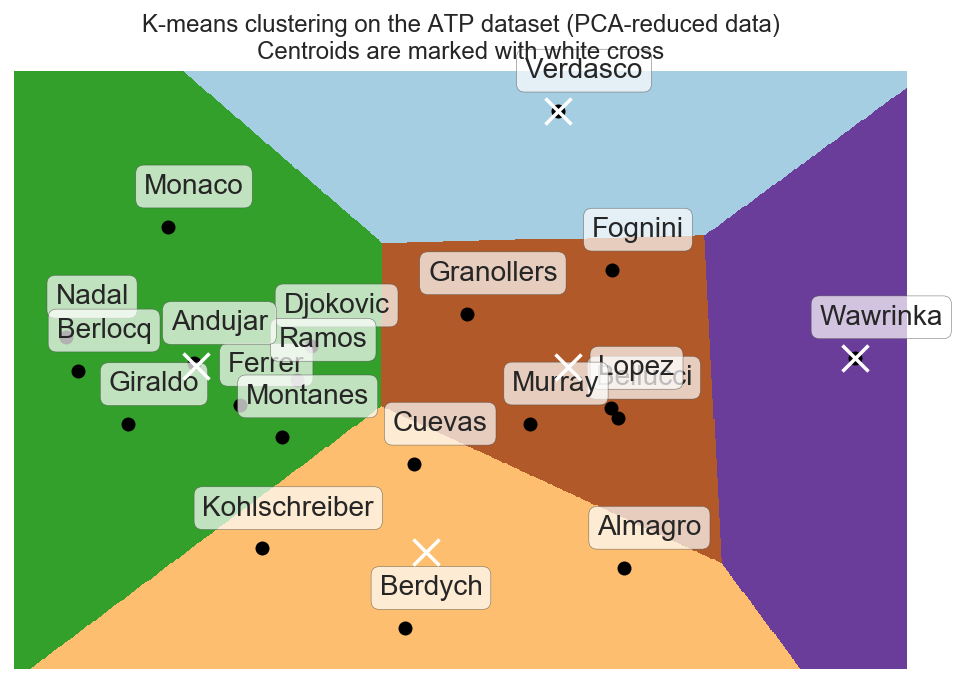

[1 1 2 4 1 1 0 3 4 2 1 2 1 1 1 4 2 4 4 1]
['Rafael Nadal', 'David Ferrer', 'Nicolas Almagro', 'Fabio Fognini', 'Juan Monaco', 'Novak Djokovic', 'Fernando Verdasco', 'Stanislas Wawrinka', 'Thomaz Bellucci', 'Philipp Kohlschreiber', 'Albert Montanes', 'Tomas Berdych', 'Albert Ramos', 'Santiago Giraldo', 'Pablo Andujar', 'Guillermo Garcia Lopez', 'Pablo Cuevas', 'Andy Murray', 'Marcel Granollers', 'Carlos Berlocq']
[ 0.7774349  -4.02457822]
[-2.01355173 -1.15750677]


,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Rafael Nadal,3.095718,1.513854,70.299748,48.251889,35.821159,12.833753,11.642317,4.312343,3.040302
David Ferrer,3.103627,2.225389,73.246114,46.406736,34.119171,15.344560,11.888601,4.841969,3.290155
Nicolas Almagro,9.087866,2.263598,77.552301,44.029289,34.732218,19.255230,12.740586,4.267782,2.912134
Fabio Fognini,3.442105,3.615789,80.794737,48.231579,34.357895,16.968421,12.557895,6.684211,4.205263
Juan Monaco,2.305085,1.638418,73.237288,50.322034,34.971751,12.824859,11.468927,5.813559,3.853107


In [17]:
# clay

stats_columns = ['winner_name','surface','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']
df['count'] = df[df['surface']=='Clay'].groupby('winner_name')['winner_name'].transform('count')
player_statistics = df.loc[df['count'].sort_values(ascending=False).index][stats_columns].groupby(['winner_name'], sort=False).agg(['mean'])

top30 = player_statistics.iloc[:20]
top30_list = [top30]#, player_statistics[player_statistics.index.str.contains('Karlovic')]]
top30p = pd.concat(top30_list)
    
labels = top30p.index.tolist()
features = top30p.as_matrix()

plot_clustering(features,labels,image_name = 'clustering_clay')

top30p.head()

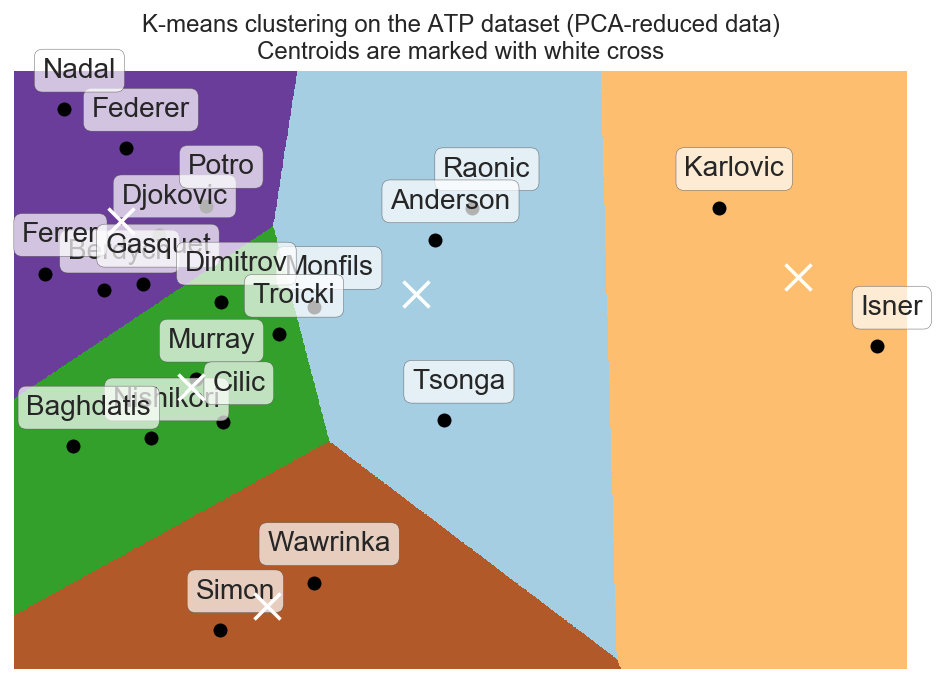

[3 1 3 3 3 3 2 1 0 0 1 4 3 0 0 3 4 1 1 1 2]
['Novak Djokovic', 'Andy Murray', 'Roger Federer', 'Tomas Berdych', 'David Ferrer', 'Rafael Nadal', 'John Isner', 'Kei Nishikori', 'Jo Wilfried Tsonga', 'Milos Raonic', 'Marin Cilic', 'Stanislas Wawrinka', 'Richard Gasquet', 'Gael Monfils', 'Kevin Anderson', 'Juan Martin Del Potro', 'Gilles Simon', 'Marcos Baghdatis', 'Grigor Dimitrov', 'Viktor Troicki', 'Ivo Karlovic']
[ 17.02587336   1.22204216]
[-1.69402427 -2.52335708]


,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpFaced,w_bpSaved
,mean,mean,mean,mean,mean,mean,mean,mean,mean
winner_name,,,,,,,,,
Novak Djokovic,5.300211,1.951374,73.911205,48.346723,36.391121,14.822410,12.289641,4.253700,2.904863
Andy Murray,7.250000,2.308673,77.206633,46.418367,35.742347,16.875000,12.688776,4.966837,3.339286
Roger Federer,7.760925,1.419023,71.123393,45.023136,36.164524,15.632391,12.262211,3.056555,2.215938
Tomas Berdych,8.446991,2.134670,73.664756,42.636103,34.378223,17.538682,12.177650,3.971347,2.896848
David Ferrer,3.103627,2.225389,73.246114,46.406736,34.119171,15.344560,11.888601,4.841969,3.290155


In [18]:
# Hardcourt
stats_columns = ['winner_name','surface','w_ace', 'w_df', 'w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved']
df['count'] = df[df['surface']=='Hard'].groupby('winner_name')['winner_name'].transform('count')
player_statistics = df.loc[df['count'].sort_values(ascending=False).index][stats_columns].groupby(['winner_name'], sort=False).agg(['mean'])

top30 = player_statistics.iloc[:20]
top30_list = [top30, player_statistics[player_statistics.index.str.contains('Karlovic')]]
top30p = pd.concat(top30_list)
    
labels = top30p.index.tolist()
features = top30p.as_matrix()

plot_clustering(features,labels,image_name = 'clustering_hard')

top30p.head()

In [20]:
df_federer = df[(df['winner_name']=='Roger Federer') | (df['loser_name']=='Roger Federer')]
print(df_federer.shape)
df_federer.head()

(493, 41)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_name,winner_hand,winner_ht,...,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,count
82,2010-1536,Madrid Masters,Clay,56,M,20100509,103819,Roger Federer,R,185.0,...,9.0,0.0,73.0,47.0,35.0,8.0,10.0,6.0,8.0,NaN
98,2010-1536,Madrid Masters,Clay,56,M,20100509,103819,Roger Federer,R,185.0,...,3.0,1.0,64.0,44.0,21.0,8.0,8.0,6.0,11.0,NaN
106,2010-1536,Madrid Masters,Clay,56,M,20100509,103819,Roger Federer,R,185.0,...,6.0,1.0,79.0,51.0,31.0,15.0,13.0,1.0,5.0,NaN
110,2010-1536,Madrid Masters,Clay,56,M,20100509,103819,Roger Federer,R,185.0,...,3.0,3.0,101.0,58.0,37.0,27.0,15.0,7.0,9.0,NaN
112,2010-1536,Madrid Masters,Clay,56,M,20100509,104745,Rafael Nadal,L,185.0,...,9.0,0.0,88.0,59.0,35.0,14.0,11.0,7.0,11.0,NaN


# Winning probability of Roger Federer over the last years

In [22]:
def convert_to_year(date_in_some_format):
    date_as_string = str(date_in_some_format)
    year_as_string = date_as_string[0:4] 
    return int(year_as_string)

df_federer['date'] = df_federer['tourney_date'].apply(convert_to_year)

In [23]:
# add important loser and winner statistics for break points
df_federer['w_bpWon'] = df_federer.apply(lambda row: row['l_bpFaced'] - row['l_bpSaved'], axis=1)
df_federer['w_bpGenerated'] = df_federer.apply(lambda row: row['l_bpFaced'], axis=1)
df_federer['l_bpWon'] = df_federer.apply(lambda row: row['w_bpFaced'] - row['w_bpSaved'], axis=1)
df_federer['l_bpGenerated'] = df_federer.apply(lambda row: row['w_bpFaced'], axis=1)

# generate two dfs for wins and loses (or only wins...)


In [24]:
df_federer[['date','surface','winner_name']].groupby(['date','surface']).count()

winner_name
date surface             
2010 Clay              14
     Grass             10
     Hard              55
2011 Clay              16
     Grass              7
     Hard              53
2012 Clay              18
     Grass             17
     Hard              52
2013 Clay              17
     Grass              6
     Hard              43
2014 Clay              12
     Grass             11
     Hard              59
2015 Clay              17
     Grass             12
     Hard              45
2016 Clay               5
     Grass             13
     Hard              10

# Winnings probability of Roger Federer of the last years

In [26]:
df_federer_l = df_federer[df_federer['loser_name']=="Roger Federer"][['date','surface','winner_name','loser_name']]
df_federer_w = df_federer[df_federer['winner_name']=="Roger Federer"][['date','surface','winner_name','loser_name']]


In [27]:
federer_lose = df_federer_l.groupby(['date','surface']).count()
federer_win = df_federer_w.groupby(['date','surface']).count()

In [28]:
federer_prob = federer_win['winner_name']/(federer_win['winner_name'] + federer_lose['winner_name'])

In [29]:
federer_prob

date  surface
2010  Clay       0.714286
      Grass      0.800000
      Hard       0.872727
2011  Clay       0.750000
      Grass      0.857143
      Hard       0.867925
2012  Clay       0.833333
      Grass      0.882353
      Hard       0.846154
2013  Clay       0.705882
      Grass      0.833333
      Hard       0.720930
2014  Clay       0.666667
      Grass      0.909091
      Hard       0.881356
2015  Clay       0.764706
      Grass      0.916667
      Hard       0.866667
2016  Clay       0.600000
      Grass      0.769231
      Hard       0.800000
Name: winner_name, dtype: float64

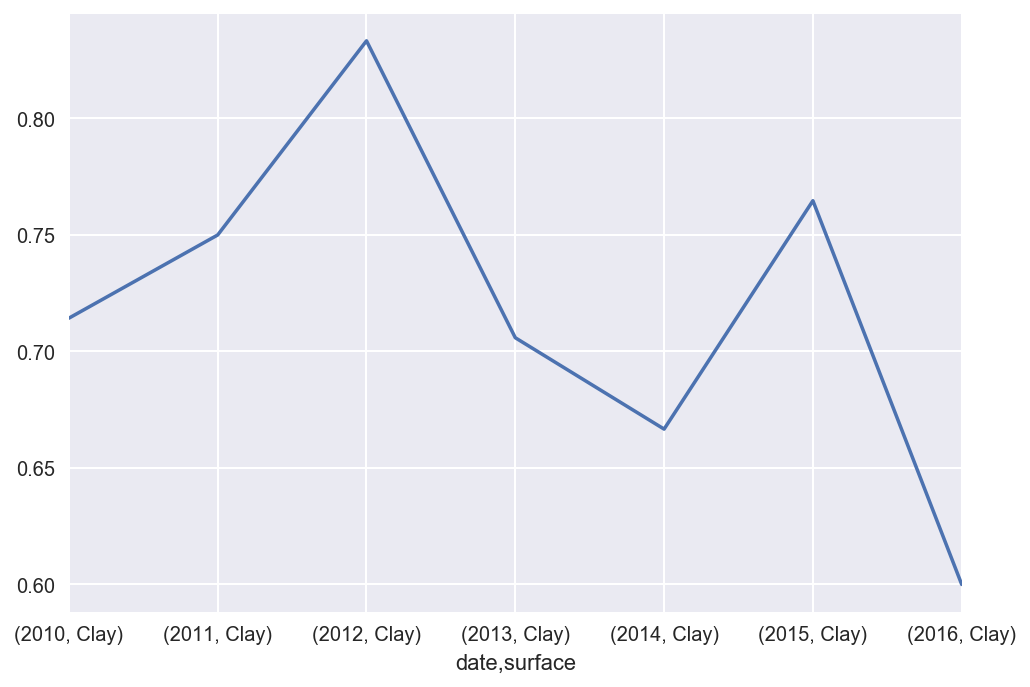

In [30]:
federer_prob.iloc[federer_prob.index.get_level_values(1) == 'Clay'].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1153e6cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x112f32cf8>], dtype=object)

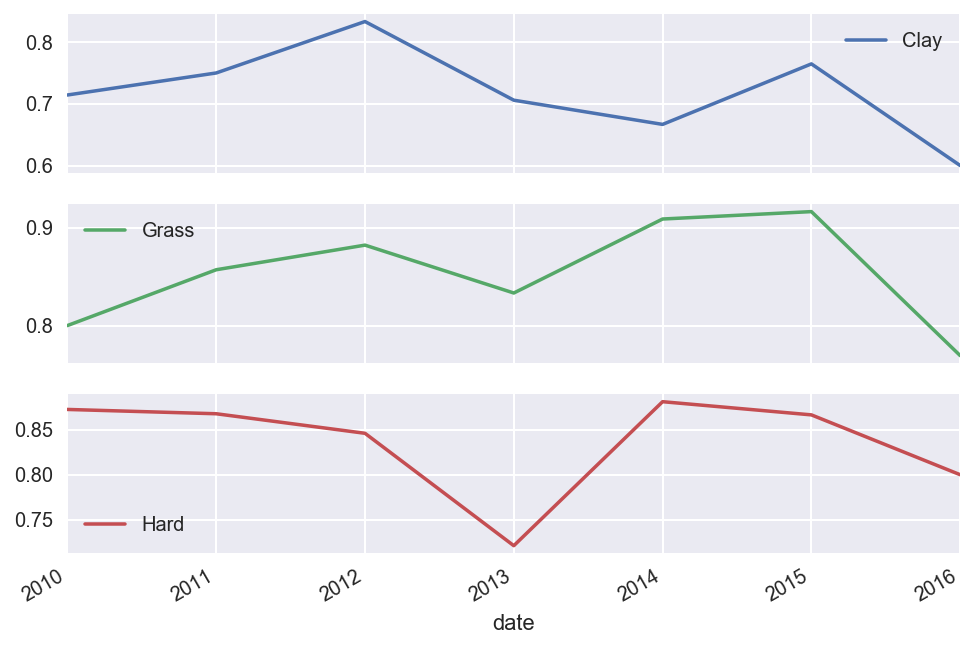

In [31]:
federer_prob.unstack(level=1).plot(subplots=True)

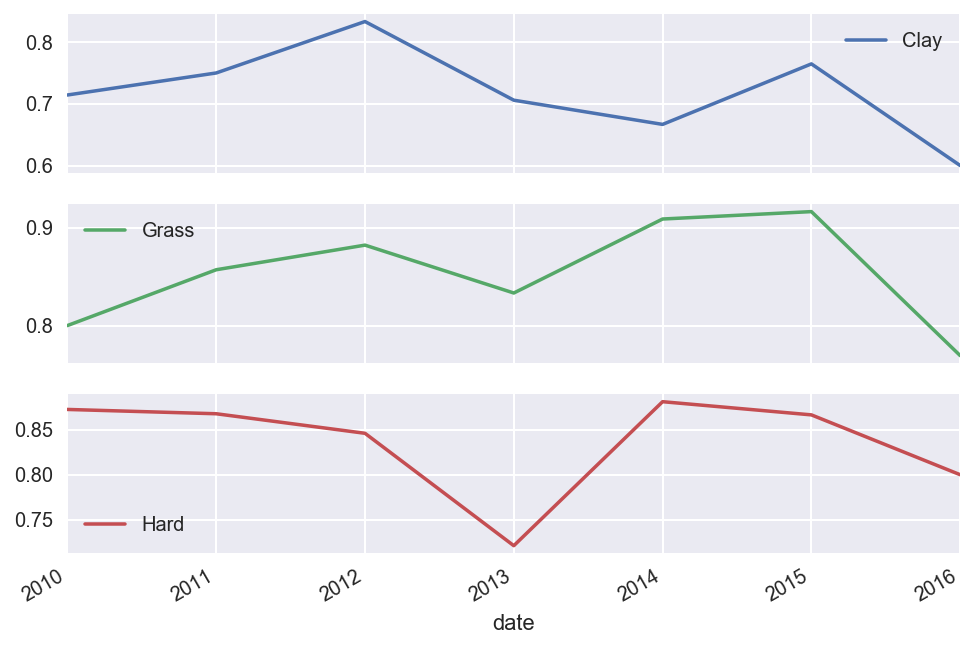

In [32]:
def plot_win_probabilities_for_surfaces(df,player):
    
    df_player = df[(df['winner_name'].str.contains(player)) | (df['loser_name'].str.contains(player))]


    def convert_to_year(date_in_some_format):
        date_as_string = str(date_in_some_format)
        year_as_string = date_as_string[0:4] 
        return int(year_as_string)

    df_player['date'] = df_player['tourney_date'].apply(convert_to_year)
    df_player_w = df_player[df_player['winner_name'].str.contains(player)][['date','surface','winner_name','loser_name']]
    df_player_l = df_player[df_player['loser_name'].str.contains(player)][['date','surface','winner_name','loser_name']]

    player_lose = df_player_l.groupby(['date','surface']).count()
    player_win = df_player_w.groupby(['date','surface']).count()

    player_prob = player_win['winner_name']/(player_win['winner_name'] + player_lose['winner_name'])
    player_prob.unstack(level=1).plot(subplots=True)
    
plot_win_probabilities_for_surfaces(df,'Federer')

# Age-Performance curve for ATP Tour players (2010-2016)

In [35]:
age_df = df[['surface','winner_name','winner_age','loser_name','loser_age']]
age_df.dropna(inplace=True)

age_df[['winner_age','loser_age']] = age_df[['winner_age','loser_age']].apply(np.floor).astype(int)
age_df.head()



,surface,winner_name,winner_age,loser_name,loser_age
0,Hard,Simon Greul,28,Paolo Lorenzi,28
1,Hard,John Isner,24,Guillermo Garcia Lopez,26
2,Hard,Juan Monaco,25,Horacio Zeballos,24
3,Hard,Michael Lammer,27,Daniel Evans,19
4,Hard,Jose Rubin Statham,22,Daniel King Turner,25


In [36]:
grouped_win = age_df.groupby('winner_age')
grouped_lose = age_df.groupby('loser_age')




# Thomas Muster is still playing?

In [37]:
age_df[age_df['loser_age']>40]

,surface,winner_name,winner_age,loser_name,loser_age
1451,Hard,Andreas Haider Maurer,23,Thomas Muster,43
4147,Clay,Philipp Kohlschreiber,27,Thomas Muster,43
4380,Hard,Dominic Thiem,18,Thomas Muster,44


In [39]:
loser_ages = grouped_lose.sum().index.values
loser_ages_count = grouped_lose.sum().winner_age.values
winner_ages = grouped_win.sum().index.values
winner_ages_count = grouped_win.sum().loser_age.values

In [44]:
short_loser_ages = grouped_lose.sum().loc[winner_ages]
age_performance = grouped_win.sum()['loser_age']/(grouped_win.sum()['loser_age']+short_loser_ages['winner_age'])



X = age_performance.index.values
y = age_performance.as_matrix()


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([("polynomial_features",  PolynomialFeatures(degree=2)),
                     ("linear_regression", LinearRegression(fit_intercept=False))])
pipeline.fit(X[:, np.newaxis], y)

grid = np.arange(16,38,1)

quad = pipeline.predict(grid[:,np.newaxis])
quad


array([ 0.27003522,  0.30972418,  0.34612974,  0.37925192,  0.4090907 ,
        0.43564609,  0.45891809,  0.4789067 ,  0.49561191,  0.50903373,
        0.51917216,  0.52602719,  0.52959884,  0.52988709,  0.52689195,
        0.52061341,  0.51105148,  0.49820617,  0.48207745,  0.46266535,
        0.43996985,  0.41399096])

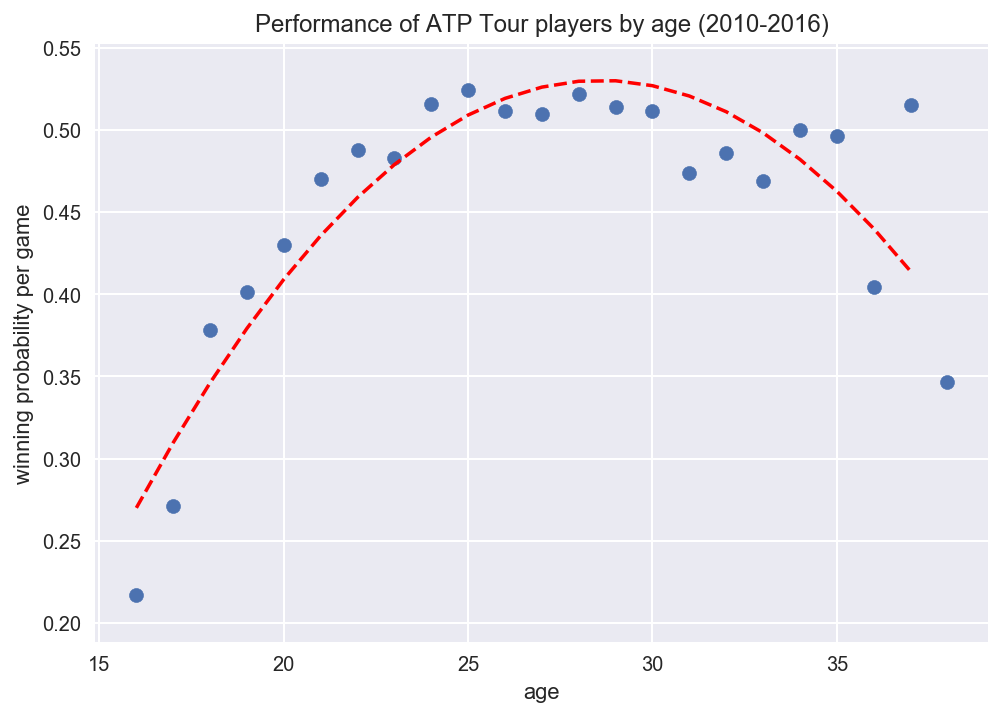

In [45]:
image_name = 'age_performance_curve'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(age_performance.index,age_performance.values)
#ax = age_performance.plot(marker='o',xticks=age_performance.index)
ax.set_xlabel('age')
ax.set_ylabel('winning probability per game')
ax.set_title('Performance of ATP Tour players by age (2010-2016)')
plt.plot(grid,quad,'--r')



plt.savefig('images/week6/{}.png'.format(image_name), bbox_inches="tight")